Taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.
Use **ImageNet**(already trained architecture that can be used to our own model)

In [1]:
!nvidia-smi

Mon Aug 21 03:52:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-08-21 03:52:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.5MB/s    in 4.6s    

2023-08-21 03:53:01 (34.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

Preparing our data. Use ImageDataGenerator to load our images in batches

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224, 224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


Setting up callbacks
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
1. Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
2. Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
3. Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [5]:
# create tensorboard callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Create models using tensorflow hub
Access pretrained models from "tensorflow hub" website.


In [6]:
# create models using tensorflow hub
#Access pretrained models from tensorflow hub
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [7]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):

  #Download the pretrained model and save it as a Keras layer.
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  #Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])
  return model

Creating and testing Resnet Tensorflow Hub Feature extraction model

In [8]:
# create resnet model
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

In [9]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# Lets fit the resnet model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                           experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v220230821-035322
Epoch 1/5
24/24 [==============================] - 26s 551ms/step - loss: 1.8114 - accuracy: 0.3973 - val_loss: 1.1420 - val_accuracy: 0.6308
Epoch 2/5
24/24 [==============================] - 10s 450ms/step - loss: 0.8663 - accuracy: 0.7387 - val_loss: 0.8217 - val_accuracy: 0.7364
Epoch 3/5
24/24 [==============================] - 10s 444ms/step - loss: 0.6078 - accuracy: 0.8240 - val_loss: 0.7286 - val_accuracy: 0.7656
Epoch 4/5
24/24 [==============================] - 13s 564ms/step - loss: 0.4654 - accuracy: 0.8773 - val_loss: 0.6839 - val_accuracy: 0.7852
Epoch 5/5
24/24 [==============================] - 14s 584ms/step - loss: 0.3678 - accuracy: 0.9187 - val_loss: 0.6590 - val_accuracy: 0.7868


In [12]:
import pandas as pd
pd.DataFrame(resnet_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.811427,0.397333,1.141969,0.6308
1,0.866328,0.738667,0.821653,0.7364
2,0.607793,0.824000,0.728580,0.7656
3,0.465404,0.877333,0.683938,0.7852
4,0.367752,0.918667,0.659039,0.7868


In [13]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='training_loss')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

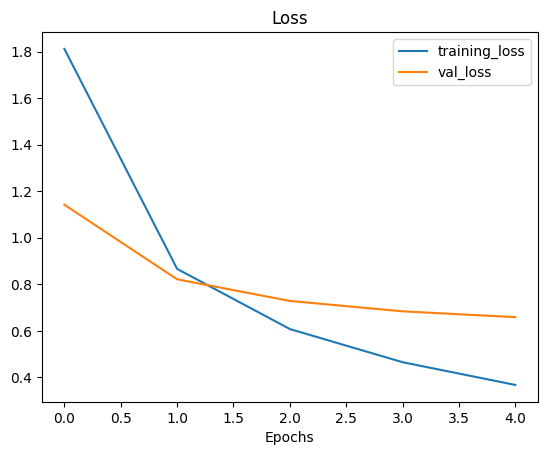

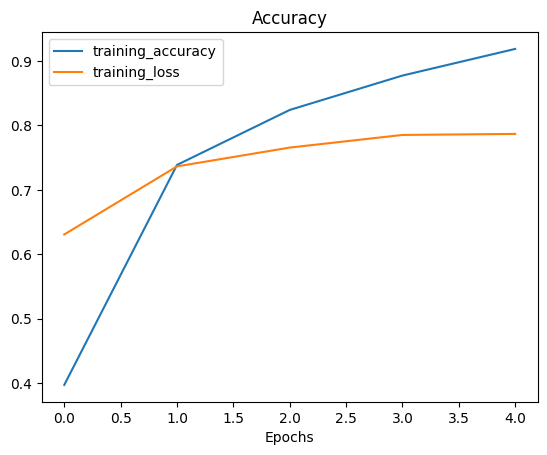

In [14]:
plot_loss_curves(resnet_history)

Creating and testing EfficientNet Tensorflow Hub features extraction model

In [15]:
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB020230821-035447
Epoch 1/5
24/24 [==============================] - 25s 627ms/step - loss: 1.8516 - accuracy: 0.4480 - val_loss: 1.2693 - val_accuracy: 0.7224
Epoch 2/5
24/24 [==============================] - 13s 540ms/step - loss: 1.0427 - accuracy: 0.7827 - val_loss: 0.8495 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 10s 411ms/step - loss: 0.7380 - accuracy: 0.8400 - val_loss: 0.6822 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 9s 396ms/step - loss: 0.5931 - accuracy: 0.8907 - val_loss: 0.6001 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 10s 431ms/step - loss: 0.5014 - accuracy: 0.8880 - val_loss: 0.5465 - val_accuracy: 0.8644


In [16]:
pd.DataFrame(efficientnet_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.851639,0.448000,1.269263,0.7224
1,1.042686,0.782667,0.849478,0.8152
2,0.738042,0.840000,0.682222,0.8396
3,0.593132,0.890667,0.600111,0.8496
4,0.501413,0.888000,0.546533,0.8644


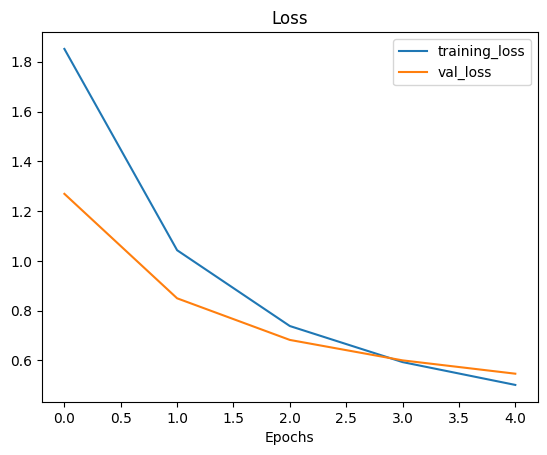

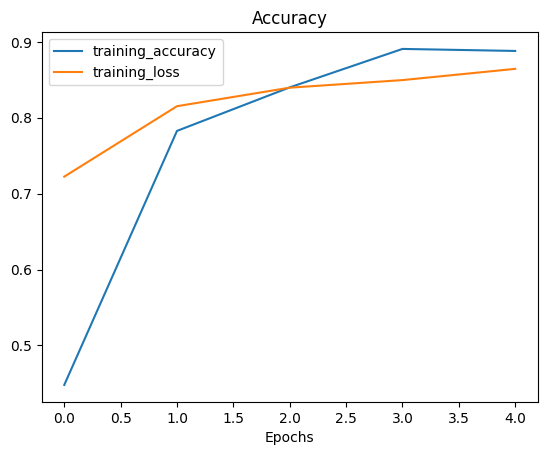

In [17]:
plot_loss_curves(efficientnet_history)

In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 8s 100ms/step - loss: 0.5465 - accuracy: 0.8644


[0.5465330481529236, 0.8644000291824341]

### Comparing our models using Tensorboard
Tensorboard is a way to visually explore machine learning models performance and internals

In [20]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-08-21 03:56:07.198169: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   CRP-JJL-JLQ



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex